In [5]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score


In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [9]:
X = sorted(glob('/Users/anshugusain/tf-nuclei/content/training_X_STARDIST_256/*.png'))
Y = sorted(glob('/Users/anshugusain/tf-nuclei/content/training_y_STARDIST_256/*.png'))

In [10]:
X = np.array(X)
Y = np.array(Y)

In [11]:
X.shape

(30,)

In [12]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [13]:
X.shape

AttributeError: 'list' object has no attribute 'shape'

In [14]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  30
- training:        26
- validation:       4


In [15]:
X_trn = np.squeeze(np.array(X_trn))
Y_trn = np.squeeze(np.array(Y_trn))
X_val = np.squeeze(np.array(X_val))
Y_val = np.squeeze(np.array(Y_val))

In [16]:
X_trn.shape

(26, 256, 256, 3)

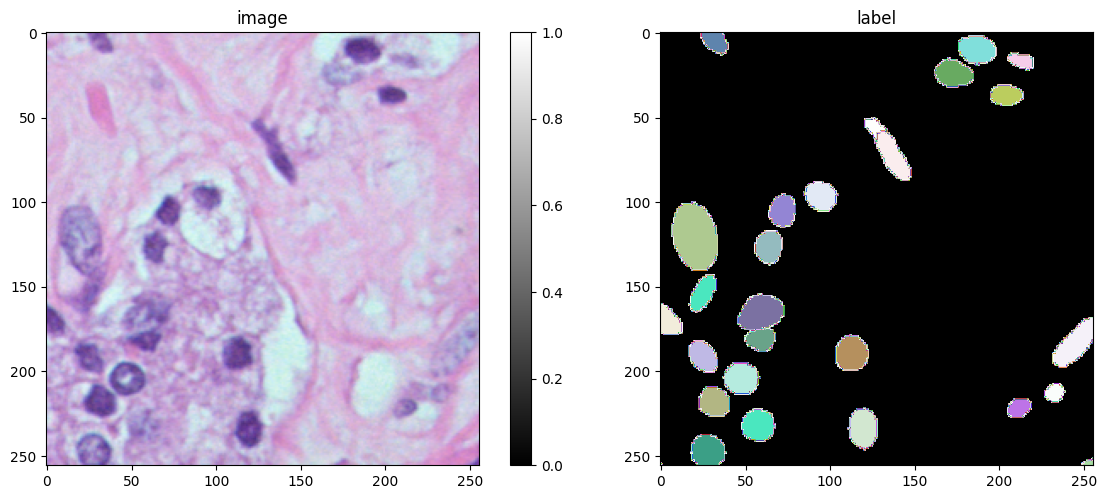

In [17]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img.squeeze(), cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    
    
i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
#assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)

In [18]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [19]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.


# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 1,
    unet_dropout = 0.1

    
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.1, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=1, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.1,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [20]:
model = StarDist2D(conf, name='stardist_training')

base_model.py (149): output path for model already exists, files may be overwritten: /Users/anshugusain/tf-nuclei/stardist_training
2023-05-16 08:54:30.212023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 08:54:30.212047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [21]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(Y[0], np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2023-05-16 08:54:31.990934: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-16 08:54:32.049949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step
median object size:      [20.  21.5]
network field of view :  [92 93]


In [22]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


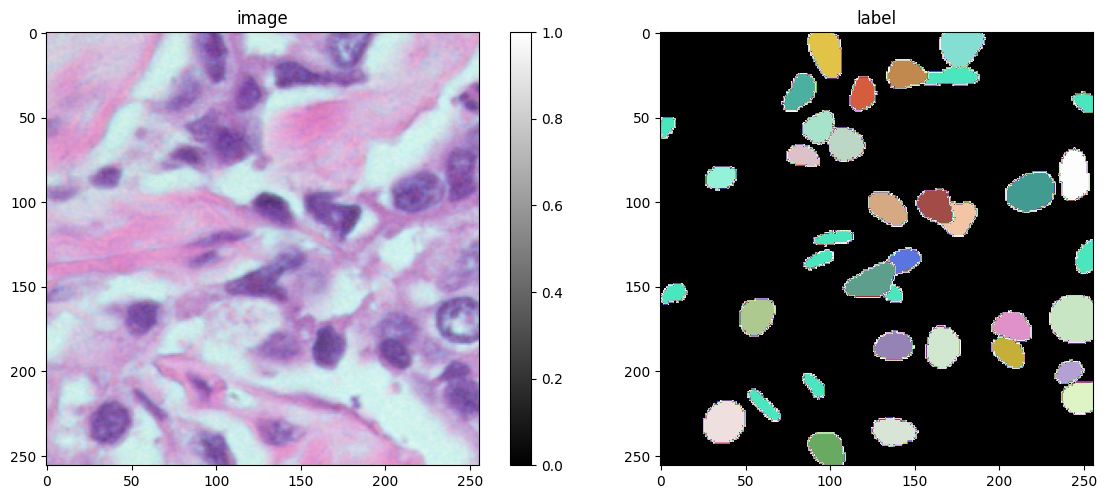

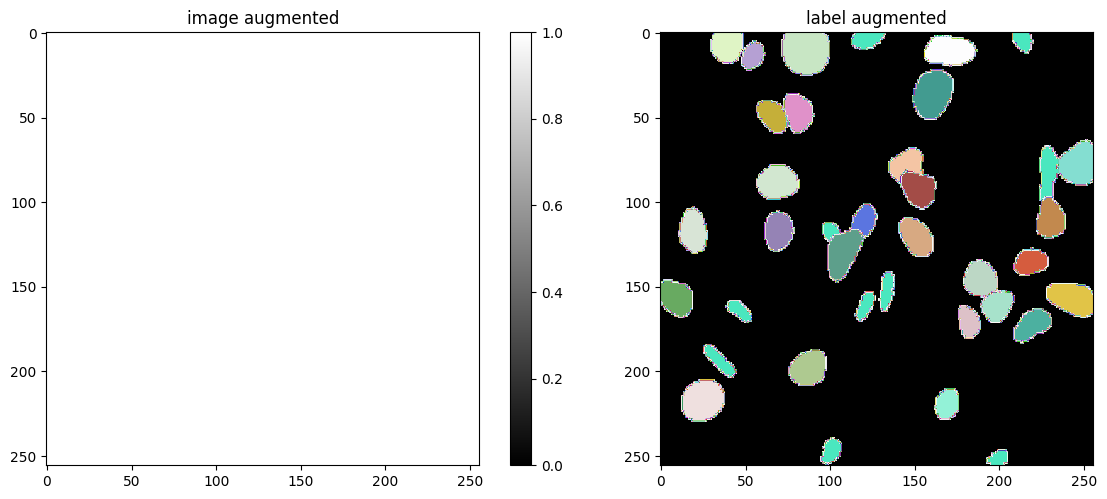

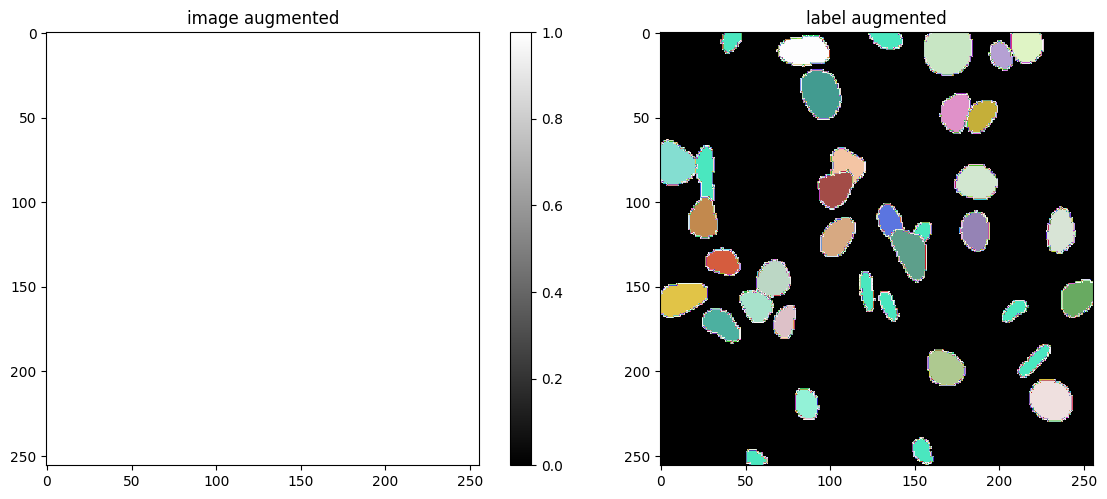

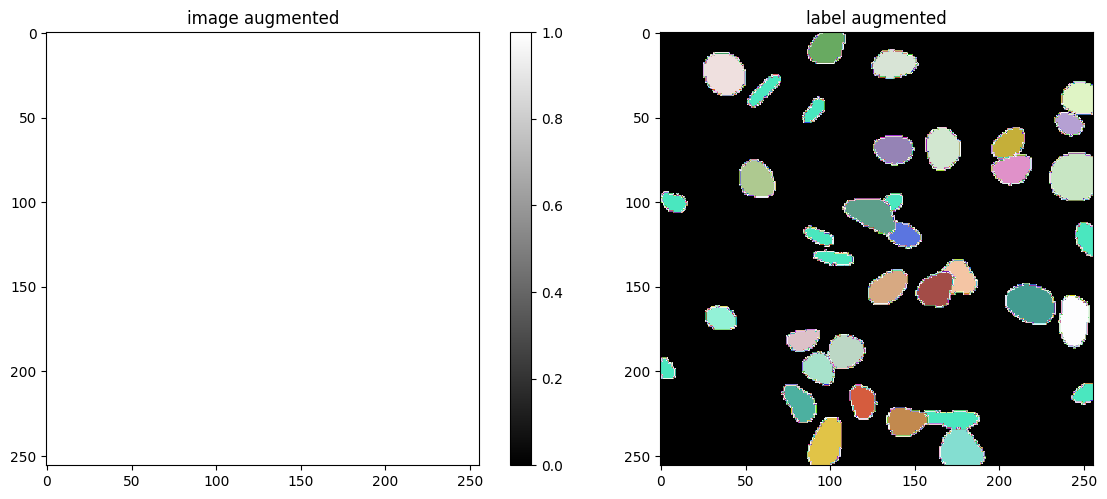

In [23]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")
    

In [24]:
model.train(X_trn.squeeze(), Y_trn.squeeze(),validation_data=(X_val.squeeze(),Y_val.squeeze()), epochs=10, augmenter=augmenter,steps_per_epoch=100)

Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Cause: Unable to locate the source code of <function _gcd_import at 0x1024f43a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x1024f43a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If

2023-05-16 08:54:43.909558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-16 08:54:45.355013: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x2c3e95e10
2023-05-16 08:54:45.355100: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x2c3e95e10
2023-05-16 08:54:45.397458: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x2c3e95e10
2023-05-16 08:54:45.397482: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x2c3e95e10
2023-05-16 08:54:45.406034: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_36' defined at (most recent call last):
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/yf/x207zzm95xxfdgm38m2klb440000gn/T/ipykernel_28942/1150292915.py", line 1, in <module>
      model.train(X_trn.squeeze(), Y_trn.squeeze(),validation_data=(X_val.squeeze(),Y_val.squeeze()), epochs=10, augmenter=augmenter,steps_per_epoch=100)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/stardist/models/model2d.py", line 452, in train
      history = fit(iter(self.data_train), validation_data=data_val,
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_36'
Detected at node 'StatefulPartitionedCall_36' defined at (most recent call last):
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/yf/x207zzm95xxfdgm38m2klb440000gn/T/ipykernel_28942/1150292915.py", line 1, in <module>
      model.train(X_trn.squeeze(), Y_trn.squeeze(),validation_data=(X_val.squeeze(),Y_val.squeeze()), epochs=10, augmenter=augmenter,steps_per_epoch=100)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/stardist/models/model2d.py", line 452, in train
      history = fit(iter(self.data_train), validation_data=data_val,
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_36'
2 root error(s) found.
  (0) NOT_FOUND:  could not find registered platform with id: 0x2c3e95e10
	 [[{{node StatefulPartitionedCall_36}}]]
	 [[gradient_tape/model/concatenate_2/Slice/_52]]
  (1) NOT_FOUND:  could not find registered platform with id: 0x2c3e95e10
	 [[{{node StatefulPartitionedCall_36}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6057]

In [ ]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

In [227]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


base.py (395): Predicting on non-float input... ( forgot to normalize? )
 50%|█████     | 2/4 [00:00<00:00, 12.28it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 4/4 [00:00<00:00, 10.21it/s]


In [104]:
def average_IoU(X_test, y_test):
  IoUs = [len(X_test)]
  total =0
  average =0

  for i in range(0,len(X_test)):
    test_predict = model.predict_instances(X_test[i])
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict[0]>.5).squeeze(), y_test[i].squeeze()>0, average='micro')
    total =IoU + total

  average = total / len(X_test)
  return average


In [105]:
def average_Fscore(X_test, y_test):
  IoUs = [len(X_test)]
  total =0
  average =0

  for i in range(0,len(X_test)):
    test_predict = np.asarray(model.predict_instances(X_test[i]))
    IoU = jaccard_score((test_predict[0]>.5).squeeze(), y_test[i].squeeze()>0, average='micro')
    total =IoU + total

  average = total / len(X_test)
  return average


In [106]:
average_Fscore(X_val, Y_val)

base.py (395): Predicting on non-float input... ( forgot to normalize? )


1/1 [==============================] - 0s 22ms/step


<ipython-input-105-d355fc37e84f> (7): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
base.py (395): Predicting on non-float input... ( forgot to normalize? )
<ipython-input-105-d355fc37e84f> (7): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
base.py (395): Predicting on non-float input... ( forgot to normalize? )
<ipython-input-105-d355fc37e84f> (7): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
base.py (395): Predicti

1/1 [==============================] - 0s 27ms/step


<ipython-input-105-d355fc37e84f> (7): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6524586875351688

In [107]:
average_IoU(X_val,Y_val)

1/1 [==============================] - 0s 21ms/step


base.py (395): Predicting on non-float input... ( forgot to normalize? )
<ipython-input-104-a4beece83f93> (8): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
base.py (395): Predicting on non-float input... ( forgot to normalize? )
<ipython-input-104-a4beece83f93> (8): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
base.py (395): Predicting on non-float input... ( forgot to normalize? )


1/1 [==============================] - 0s 22ms/step


<ipython-input-104-a4beece83f93> (8): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
base.py (395): Predicting on non-float input... ( forgot to normalize? )
<ipython-input-104-a4beece83f93> (8): Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.6524586875351688

1/1 [==============================] - 0s 22ms/step


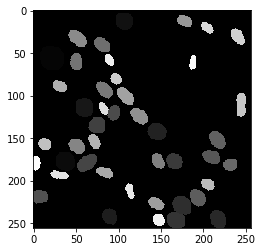

In [233]:

y_pred_1 = model.predict_instances(X_val[0])
plt.imshow(y_pred_1[0],cmap='gray')

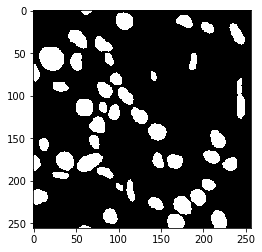

In [234]:
plt.imshow(Y_val[0]>0, cmap='gray')

In [235]:
IoU = jaccard_score((Y_val[0]>0).squeeze(), y_pred_1[0]>0, average='samples')
IoU

0.7669429544535382

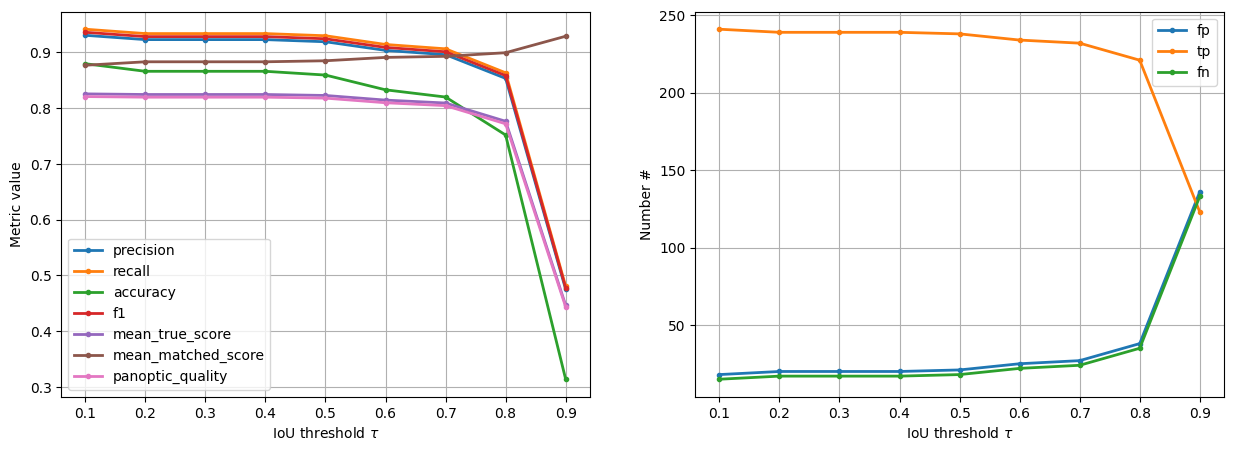

In [ ]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();



1/1 [==============================] - 0s 86ms/step


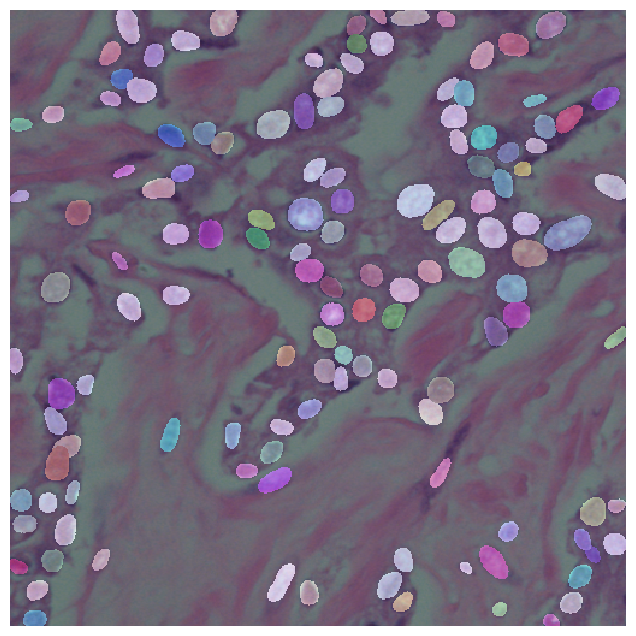

In [ ]:
img_num = randint(0, len(X)-1)
img = X[0]
#img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)


plt.figure(figsize=(8,8))
plt.imshow(img)
#plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');


In [ ]:
#Plot 

def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show ); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    
example(model, 16)

IndexError: index 16 is out of bounds for axis 0 with size 16

Text(0, 0.5, 'IoU score')

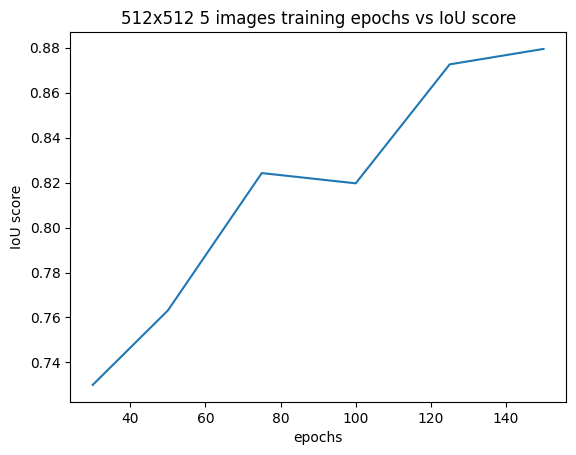

In [ ]:
plt.plot([30, 50, 75, 100, 125, 150], [.73, 0.7631020096238507, 0.8242218883150952, 0.8196649780145147, 0.8725719218549207,0.8794466420542153])
plt.title("512x512 5 images training epochs vs IoU score")
plt.xlabel("epochs")
plt.ylabel("IoU score")

Text(0, 0.5, 'IoU score')

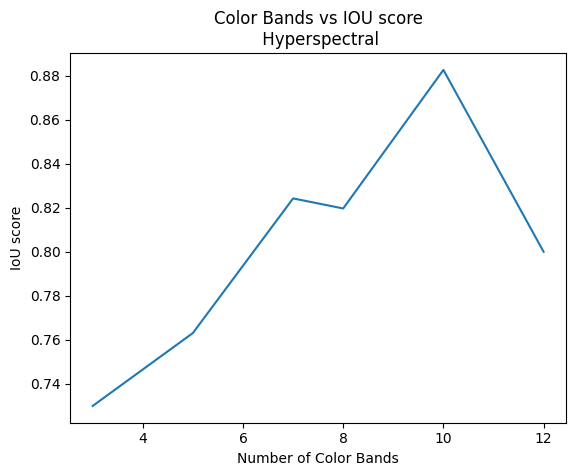

In [10]:
plt.plot([3, 5, 7, 8, 10, 12], [.73, 0.7631020096238507, 0.8242218883150952, 0.8196649780145147, 0.8825719218549207,0.80])
plt.title("""Color Bands vs IOU score
 Hyperspectral""")
plt.xlabel("Number of Color Bands")
plt.ylabel("IoU score")

Text(0.5, 1.0, '256x256 training epochs vs IoU score')

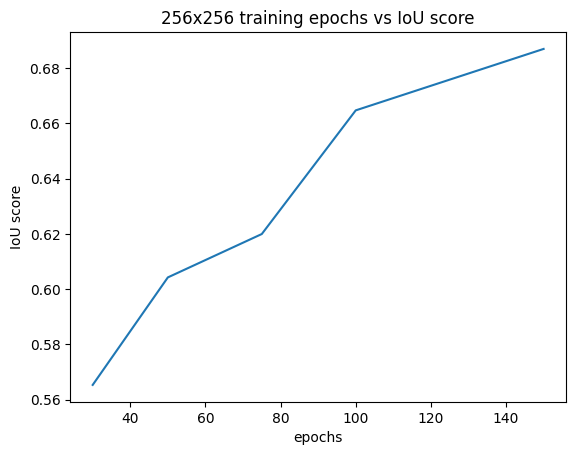

In [ ]:
plt.plot([30,50,75,100,150], [0.5653699043059233,0.6042534690790466,0.8500657877300872,0.6646589098789917,0.686882603421433])
plt.xlabel("epochs")
plt.ylabel("IoU score")
plt.title("256x256 training epochs vs IoU score")

Text(0.5, 1.0, '512x512 1 image score on different epochs')

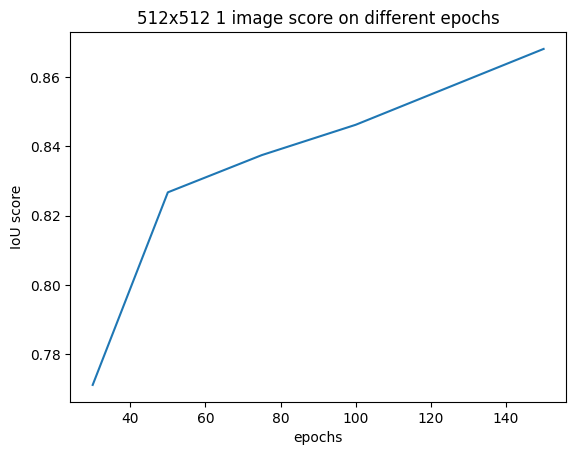

In [ ]:
plt.plot([30,50,75,100,150], [0.7711113800335422,0.8267177072514532,0.8374640890162244,0.8462243720521072,0.8681224526860325])
plt.xlabel("epochs")
plt.ylabel("IoU score")
plt.title("512x512 1 image score on different epochs")

Text(0.5, 1.0, '512x512 2 image score on different epochs')

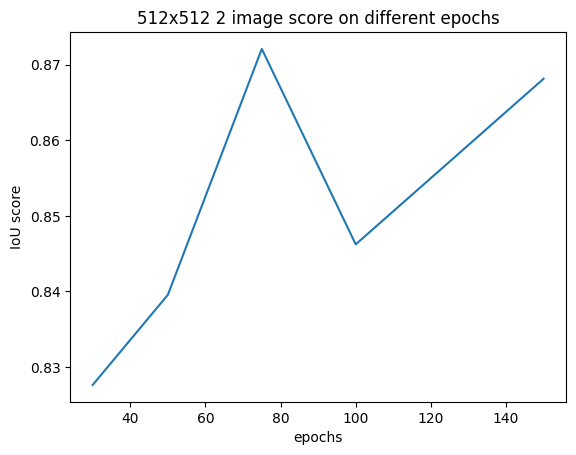

In [ ]:
plt.plot([30,50,75,100,150], [0.8276381419234025,0.8395499564643047,0.87206649418443,0.8462243720521072,0.8681224526860325])
plt.xlabel("epochs")
plt.ylabel("IoU score")
plt.title("512x512 2 image score on different epochs")

Text(0.5, 1.0, '512x512 3 image score on different epochs')

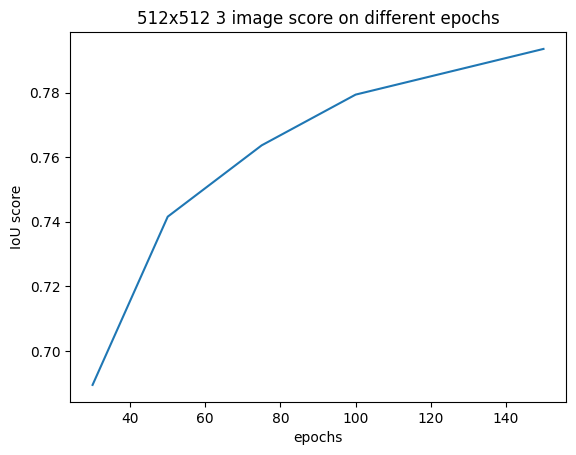

In [ ]:
plt.plot([30,50,75,100,150], [0.689462024653821,0.7415815325018495,0.7636752366451769,0.7793920272100374,0.7935475853252226])
plt.xlabel("epochs")
plt.ylabel("IoU score")
plt.title("512x512 3 image score on different epochs")

Text(0.5, 1.0, '512x512 4 image score on different epochs')

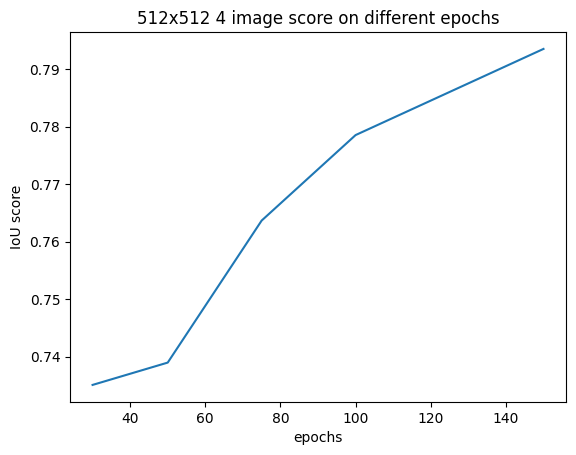

In [ ]:
plt.plot([30,50,75,100,150], [0.7350650073666654,0.7389518226002023,0.7636752366451769,0.7785544470405883,0.7935475853252226])
plt.xlabel("epochs")
plt.ylabel("IoU score")
plt.title("512x512 4 image score on different epochs")

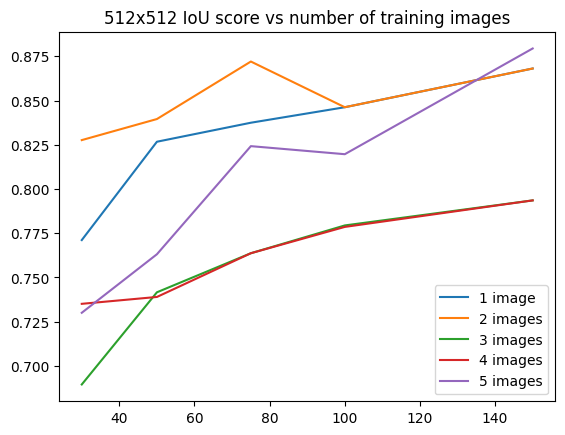

In [ ]:
m = [30,50,75,100,150]
y1 = [0.7711113800335422,0.8267177072514532,0.8374640890162244,0.8462243720521072,0.8681224526860325]
y2 = [0.8276381419234025,0.8395499564643047,0.87206649418443,0.8462243720521072,0.8681224526860325]
y3 = [0.689462024653821,0.7415815325018495,0.7636752366451769,0.7793920272100374,0.7935475853252226]
y4 = [0.7350650073666654,0.7389518226002023,0.7636752366451769,0.7785544470405883,0.7935475853252226]
y5 = [.73, 0.7631020096238507, 0.8242218883150952, 0.8196649780145147,0.8794466420542153]

# plot lines
plt.title("512x512 IoU score vs number of training images")
plt.plot(m, y1, label = "1 image")
plt.plot(m, y2, label = '2 images')
plt.plot(m, y3, label='3 images')
plt.plot(m, y4,label= '4 images')
plt.plot(m, y5, label='5 images')
plt.legend()
plt.show()

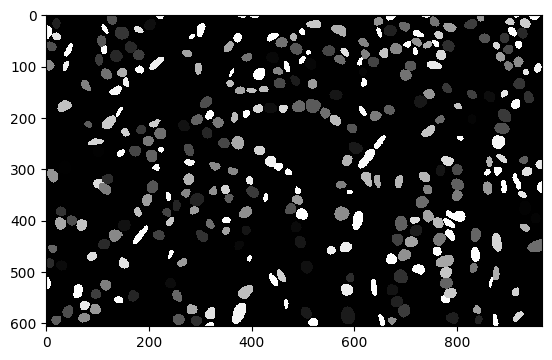

In [ ]:
path = '/Users/anshugusain/tf-nuclei/env/content/Field-005-mask-STARDIST.tif'
sdf = image.load_img(path)
plt.imshow(sdf, cmap=lbl_cmap)